In [1]:
import torch
torch.cuda.empty_cache()


In [2]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

print("✅ Transformers and BERT loaded successfully with PyTorch")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Transformers and BERT loaded successfully with PyTorch


In [3]:
#eda
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Load dataset
train = pd.read_csv('train1.csv')




In [4]:
# Percentage distribution
print(train['label'].value_counts(normalize=True))

label
0    0.929854
1    0.070146
Name: proportion, dtype: float64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB
None
   id  label                                              tweet
0   1      0   @user when a father is dysfunctional and is s...
1   2      0  @user @user thanks for #lyft credit i can't us...
2   3      0                                bihday your majesty
3   4      0  #model   i love u take with u all the time in ...
4   5      0             factsguide: society now    #motivation


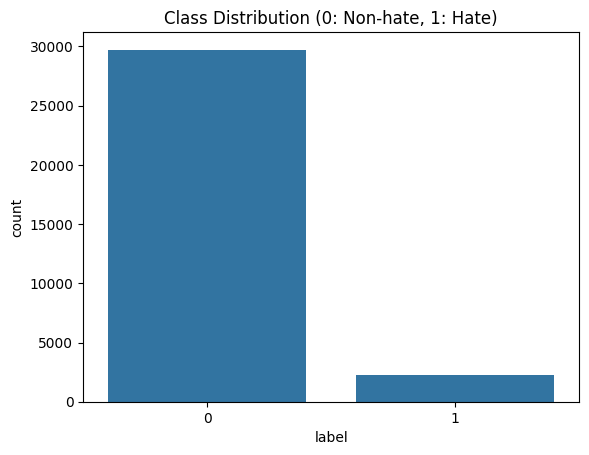

In [5]:
# Basic info
print(train.info())
print(train.head())

# Check class distribution
sns.countplot(x='label', data=train)
plt.title('Class Distribution (0: Non-hate, 1: Hate)')
plt.show()

In [6]:
# Check for missing values
print(train.isnull().sum())

id       0
label    0
tweet    0
dtype: int64


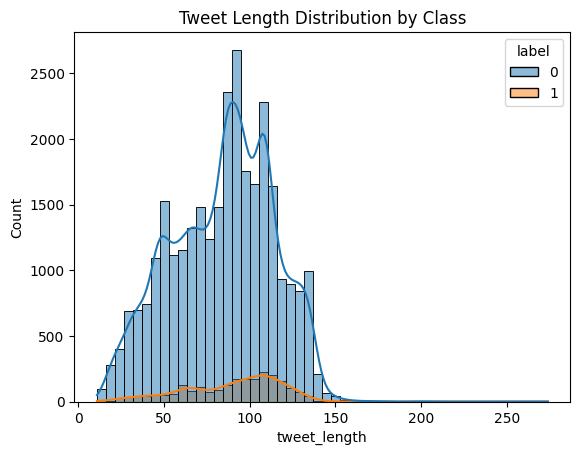

In [7]:
# Tweet length distribution
train['tweet_length'] = train['tweet'].apply(len)
sns.histplot(data=train, x='tweet_length', hue='label', bins=50, kde=True)
plt.title('Tweet Length Distribution by Class')
plt.show()

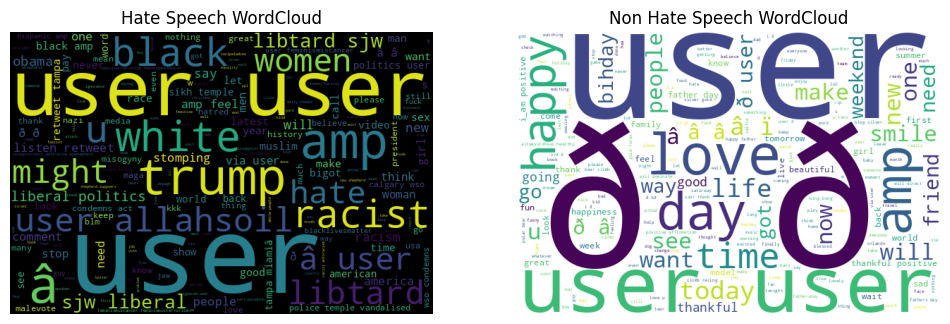

In [8]:

# WordCloud for each class
hate_speech_text = ' '.join(train[train['label']==1]['tweet'])
non_hate_text = ' '.join(train[train['label']==0]['tweet'])

wc_hate = WordCloud(width=600, height=400, background_color='black').generate(hate_speech_text)
wc_non_hate = WordCloud(width=600, height=400, background_color='white').generate(non_hate_text)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(wc_hate)
plt.title('Hate Speech WordCloud')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(wc_non_hate)
plt.title('Non Hate Speech WordCloud')
plt.axis('off')

plt.show()


In [9]:
import re

def clean_text(text):
    text = re.sub(r"http\S+", "", text)         # Remove URLs
    text = re.sub(r"@\w+", "", text)            # Remove @mentions
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text) # Remove special chars except spaces/numbers/letters
    text = text.strip()
    return text

train['clean_tweet'] = train['tweet'].apply(clean_text)


In [10]:
#encode
from transformers import BertTokenizer
from sklearn.preprocessing import LabelEncoder

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def encode_tweets(tweets, max_len=128):
    return tokenizer(
        tweets.tolist(),
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

# Encode tweets
encoded_train = encode_tweets(train['clean_tweet'])

# Encode labels
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train['label'])



In [11]:
from sklearn.utils.class_weight import compute_class_weight
import torch
import numpy as np


class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = torch.tensor(class_weights, dtype=torch.float)


In [22]:
from torch.utils.data import Dataset, DataLoader
import torch

class TweetDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = TweetDataset(encoded_train, train_labels)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


In [23]:
from transformers import BertForSequenceClassification
from torch.optim import AdamW


In [24]:
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=len(np.unique(train_labels))  # Binary classification, probably 2
)

optimizer = AdamW(model.parameters(), lr=2e-5)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import numpy as np

In [29]:
# 1. Split into train and validation sets (split each field of encoded_train)
input_ids_train, input_ids_val, attention_mask_train, attention_mask_val, train_labels_split, val_labels_split = train_test_split(
    encoded_train['input_ids'], encoded_train['attention_mask'], train_labels, test_size=0.1, random_state=42
)

train_encodings = {
    'input_ids': input_ids_train,
    'attention_mask': attention_mask_train
}
val_encodings = {
    'input_ids': input_ids_val,
    'attention_mask': attention_mask_val
}


In [30]:
#create  dataset class
# 2. Create Dataset class
class TweetDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

In [31]:
# 3. Create train/val Datasets and DataLoaders
train_dataset = TweetDataset(train_encodings, train_labels_split)
val_dataset = TweetDataset(val_encodings, val_labels_split)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [32]:
# 4. Define loss and optimizer
loss_fn = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)


In [33]:
# 5. Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [35]:
import time

# Ensure class_weights is on the correct device
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

model.to(device)

# Updated TweetDataset (fixes the tensor warning)
class TweetDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}  # val[idx] is already a tensor
        item['labels'] = torch.tensor(self.labels[idx])
        return item

# Training loop
num_epochs = 2 # Can increase later

print("🚀 Starting training...")
training_start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    batch_count = 0

    for batch in train_loader:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        batch_count += 1
        print(f"  Batch {batch_count}, Loss: {loss.item():.4f}")

        # Optional: limit batches per epoch
        # if batch_count >= max_batches:
        #     break

    avg_train_loss = total_loss / batch_count
    print(f"✅ Training Loss: {avg_train_loss:.4f}")

    # Save model after each epoch
    epoch_save_path = f'model_epoch_{epoch+1}.pth'
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': avg_train_loss,
        'class_weights': class_weights.cpu(),  # Save class weights too
    }, epoch_save_path)
    print(f"💾 Model saved: {epoch_save_path}")

# Training completed - save final model
total_training_time = time.time() - training_start_time
print(f"\n🎉 Training completed in {total_training_time/60:.2f} minutes!")

# Save the final trained model
final_save_path = 'final_trained_model.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'num_epochs': num_epochs,
    'final_loss': avg_train_loss,
    'class_weights': class_weights.cpu(),
    'training_time': total_training_time,
}, final_save_path)

print(f"💾 Final model saved: {final_save_path}")
print("✅ Model is ready for testing!")

# Optional: Save just the model weights (smaller file)
torch.save(model.state_dict(), 'model_weights_only.pth')
print("💾 Model weights saved: model_weights_only.pth")

<ipython-input-35-e1686dbfe27e>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
<ipython-input-30-7bf9af45b914>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


🚀 Starting training...

Epoch 1/2
  Batch 1, Loss: 0.5776
  Batch 2, Loss: 0.8079
  Batch 3, Loss: 0.9090
  Batch 4, Loss: 0.7692
  Batch 5, Loss: 0.7690
  Batch 6, Loss: 0.7041
  Batch 7, Loss: 0.6717
  Batch 8, Loss: 0.7123
  Batch 9, Loss: 0.6849
  Batch 10, Loss: 0.6300
  Batch 11, Loss: 0.6396
  Batch 12, Loss: 0.7353
  Batch 13, Loss: 0.6223
  Batch 14, Loss: 0.6682
  Batch 15, Loss: 0.6265
  Batch 16, Loss: 0.6552
  Batch 17, Loss: 0.5802
  Batch 18, Loss: 0.6210
  Batch 19, Loss: 0.6848
  Batch 20, Loss: 0.5932
  Batch 21, Loss: 0.5735
  Batch 22, Loss: 0.6827
  Batch 23, Loss: 0.4609
  Batch 24, Loss: 0.5084
  Batch 25, Loss: 0.6206
  Batch 26, Loss: 0.6586
  Batch 27, Loss: 0.6491
  Batch 28, Loss: 0.6478
  Batch 29, Loss: 0.5036
  Batch 30, Loss: 0.5975
  Batch 31, Loss: 0.6102
  Batch 32, Loss: 0.4821
  Batch 33, Loss: 0.4725
  Batch 34, Loss: 0.4502
  Batch 35, Loss: 0.5860
  Batch 36, Loss: 0.4843
  Batch 37, Loss: 0.4598
  Batch 38, Loss: 0.5743
  Batch 39, Loss: 0.7050


In [36]:
import torch
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import time

# Step 1: Load the saved model
print("📂 Loading saved model...")
checkpoint = torch.load('final_trained_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()  # Set to evaluation mode
print("✅ Model loaded successfully!")

📂 Loading saved model...
✅ Model loaded successfully!


In [40]:
# Step 2: Load test dataset (unlabeled)
print("📂 Loading test data...")

# Load your test CSV file - REPLACE 'your_test_file.csv' with your actual file path
test_df = pd.read_csv('test1.csv')

# Extract tweets and IDs
test_texts = test_df['tweet'].tolist()
test_ids = test_df['id'].tolist()

print(f"✅ Test data loaded: {len(test_texts)} samples")
print(f"📝 Sample tweet: {test_texts[0][:100]}...")  # Show first 100 chars of first tweet
print(f"🆔 Sample ID: {test_ids[0]}")

📂 Loading test data...
✅ Test data loaded: 17197 samples
📝 Sample tweet: #studiolife #aislife #requires #passion #dedication #willpower   to find #newmaterialsâ¦ ...
🆔 Sample ID: 31963


In [41]:
# Step 3: Define class names (adjust based on your model)
class_names = ['Negative', 'Neutral', 'Positive']

In [42]:
# Step 4: Create a dataset class for unlabeled data
class TestTweetDataset(Dataset):
    def __init__(self, encodings, ids):
        self.encodings = encodings
        self.ids = ids

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['id'] = self.ids[idx]
        return item


In [43]:
# Step 5: Tokenize test data
print("🔤 Tokenizing test data...")
test_encodings = tokenizer(
    test_texts,
    truncation=True,
    padding=True,
    max_length=128,  # Use same max_length as training
    return_tensors='pt'
)

print("✅ Test data tokenized successfully!")

# Create test dataset and dataloader
test_dataset = TestTweetDataset(test_encodings, test_ids)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"📊 Test dataset ready: {len(test_dataset)} samples")

🔤 Tokenizing test data...
✅ Test data tokenized successfully!
📊 Test dataset ready: 17197 samples


In [44]:
# Step 6: Make predictions on test data
def predict_test_data(model, test_loader, device, class_names=None):
    """
    Make predictions on unlabeled test data
    """
    model.eval()

    all_predictions = []
    all_probabilities = []
    all_ids = []

    print("🔍 Making predictions on test dataset...")
    start_time = time.time()

    with torch.no_grad():  # Disable gradient computation for faster inference
        for batch_idx, batch in enumerate(test_loader):
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            batch_ids = batch['id']

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            # Get predictions and probabilities
            probabilities = torch.softmax(outputs.logits, dim=1)
            predictions = torch.argmax(outputs.logits, dim=1)

            # Store results
            all_predictions.extend(predictions.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
            all_ids.extend(batch_ids)

            # Progress update
            if (batch_idx + 1) % 10 == 0:
                print(f"  Processed {batch_idx + 1}/{len(test_loader)} batches")

    prediction_time = time.time() - start_time

    print(f"\n" + "="*50)
    print(f"🎯 PREDICTION RESULTS")
    print(f"="*50)
    print(f"  📝 Total samples processed: {len(all_predictions)}")
    print(f"  ⏱️  Prediction time: {prediction_time:.2f} seconds")
    print(f"  🏷️  Classes: {class_names if class_names else 'Numeric labels'}")

    # Show prediction distribution
    unique, counts = np.unique(all_predictions, return_counts=True)
    print(f"\n📊 PREDICTION DISTRIBUTION:")
    print("-" * 30)
    for class_idx, count in zip(unique, counts):
        class_name = class_names[class_idx] if class_names else f"Class {class_idx}"
        percentage = (count / len(all_predictions)) * 100
        print(f"  {class_name}: {count} samples ({percentage:.1f}%)")

    return {
        'ids': all_ids,
        'predictions': all_predictions,
        'probabilities': all_probabilities,
        'class_names': class_names,
        'prediction_time': prediction_time
    }


In [45]:
# Step 7: Run predictions
print("🚀 Starting predictions...")
results = predict_test_data(model, test_loader, device, class_names)


🚀 Starting predictions...
🔍 Making predictions on test dataset...
  Processed 10/538 batches
  Processed 20/538 batches
  Processed 30/538 batches
  Processed 40/538 batches
  Processed 50/538 batches
  Processed 60/538 batches
  Processed 70/538 batches
  Processed 80/538 batches
  Processed 90/538 batches
  Processed 100/538 batches
  Processed 110/538 batches
  Processed 120/538 batches
  Processed 130/538 batches
  Processed 140/538 batches
  Processed 150/538 batches
  Processed 160/538 batches
  Processed 170/538 batches
  Processed 180/538 batches
  Processed 190/538 batches
  Processed 200/538 batches
  Processed 210/538 batches
  Processed 220/538 batches
  Processed 230/538 batches
  Processed 240/538 batches
  Processed 250/538 batches
  Processed 260/538 batches
  Processed 270/538 batches
  Processed 280/538 batches
  Processed 290/538 batches
  Processed 300/538 batches
  Processed 310/538 batches
  Processed 320/538 batches
  Processed 330/538 batches
  Processed 340/538

In [47]:
# Step 8: Create results DataFrame and save
print("\n💾 Saving prediction results...")

# Create results DataFrame
results_df = pd.DataFrame({
    'id': results['ids'],
    'prediction': results['predictions'],
    'predicted_class': [class_names[pred] if class_names else f"Class_{pred}"
                        for pred in results['predictions']]
})

# Add probability columns for each class (assuming exactly 2 classes)
prob_array = np.array(results['probabilities'])

# Use only the first two class names
if class_names and len(class_names) >= 2:
    used_class_names = class_names[:2]
else:
    used_class_names = [f"Class_{i}" for i in range(2)]

# Add class probability columns
for i, class_name in enumerate(used_class_names):
    results_df[f'prob_{class_name}'] = prob_array[:, i]

# Add confidence (max probability)
results_df['confidence'] = np.max(prob_array, axis=1)

# Save to CSV
results_df.to_csv('test_predictions.csv', index=False)
print("✅ Predictions saved to: test_predictions.csv")



💾 Saving prediction results...
✅ Predictions saved to: test_predictions.csv


In [48]:
# Step 9: Display sample predictions
print(f"\n🔍 SAMPLE PREDICTIONS:")
print("-" * 60)
sample_size = min(10, len(results_df))
for i in range(sample_size):
    row = results_df.iloc[i]
    original_text = test_texts[i][:50] + "..." if len(test_texts[i]) > 50 else test_texts[i]

    print(f"ID: {row['id']}")
    print(f"Tweet: {original_text}")
    print(f"Prediction: {row['predicted_class']} (Confidence: {row['confidence']:.3f})")
    print("-" * 60)



🔍 SAMPLE PREDICTIONS:
------------------------------------------------------------
ID: 31963
Tweet: #studiolife #aislife #requires #passion #dedicatio...
Prediction: Negative (Confidence: 0.999)
------------------------------------------------------------
ID: 31964
Tweet:  @user #white #supremacists want everyone to see t...
Prediction: Neutral (Confidence: 0.998)
------------------------------------------------------------
ID: 31965
Tweet: safe ways to heal your #acne!!    #altwaystoheal #...
Prediction: Negative (Confidence: 0.996)
------------------------------------------------------------
ID: 31966
Tweet: is the hp and the cursed child book up for reserva...
Prediction: Negative (Confidence: 0.997)
------------------------------------------------------------
ID: 31967
Tweet:   3rd #bihday to my amazing, hilarious #nephew eli...
Prediction: Negative (Confidence: 0.999)
------------------------------------------------------------
ID: 31968
Tweet: choose to be   :) #momtips 
Predict

In [49]:
# Step 10: Save complete results
torch.save({
    'predictions': results,
    'results_dataframe': results_df,
    'model_path': 'final_trained_model.pth',
    'class_names': class_names
}, 'complete_test_results.pth')

print(f"\n✅ Complete results saved to: complete_test_results.pth")
print(f"📄 CSV file created: test_predictions.csv")
print(f"🎉 Prediction completed successfully!")

print(f"\n📋 SUMMARY:")
print(f"  • Processed {len(results['ids'])} tweets")
print(f"  • Results saved in CSV format with probabilities")
print(f"  • Most confident predictions shown above")
print(f"  • Ready for submission or further analysis!")


✅ Complete results saved to: complete_test_results.pth
📄 CSV file created: test_predictions.csv
🎉 Prediction completed successfully!

📋 SUMMARY:
  • Processed 17197 tweets
  • Results saved in CSV format with probabilities
  • Most confident predictions shown above
  • Ready for submission or further analysis!
